In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from pprint import pprint
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier,AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")



sns.set()

In [188]:
def MSE(y_true, y_predict):
    squared = (y_true-y_predict)**2
    return np.sum(squared) / len(y_true)

def MAE(y_true, y_predict):
    abs_val = abs(y_true-y_predict)
    return np.sum(abs_val) / len(y_true)

In [189]:
df = pd.read_excel('Realized Schedule 20210101-20220228.xlsx')
df_predict = pd.read_excel('Future Schedule 20220301-20220331.xlsx')

In [190]:
df.isna().sum()

ScheduleTime    0
Airline         0
FlightNumber    0
Destination     0
AircraftType    0
FlightType      0
Sector          0
SeatCapacity    0
LoadFactor      0
dtype: int64

In [191]:
df.head()

ScheduleTime Airline  FlightNumber Destination AircraftType  \
0 2021-01-01 06:35:00      IA           874         DEN          73W   
1 2021-01-01 10:35:00      JZ           818         YHM          AT7   
2 2021-01-01 12:05:00      IA           876         DEN          73W   
3 2021-01-01 13:20:00      CN           514         EST          AT7   
4 2021-01-01 14:20:00      LJ          3140         DEN          32A   

  FlightType Sector  SeatCapacity  LoadFactor  
0          J     US           142    0.408451  
1          J     CA            74    0.189189  
2          J     US           142    0.570423  
3          J     US            72    0.333333  
4          J     US           186    0.204301

dividing timestamp into year, day and month.

In [192]:
df['year'] = df.ScheduleTime.apply(lambda x: x.year)
df['day'] = df.ScheduleTime.apply(lambda x: x.weekday())
df['month'] = df.ScheduleTime.apply(lambda x: x.month)

Binning the hours into 4 diffreent categories. 

In [193]:
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'daytime', 'afternoon']
df['time'] = pd.cut(df.ScheduleTime.dt.hour, bins,labels=labels)

Binning the Months into vinter, spring, summer and fall.

In [194]:
bins = ["Winter", "Spring", "Summer", "Fall"]
df['Season'] = df.month%12 //3
df['Season'] = df['Season'].apply(lambda x : bins[x])

Dummy on sector, flighttype, time and Season

In [195]:
df=pd.get_dummies(df,columns=['Sector','FlightType','time', 'Season','day','year'],drop_first=True)

Cleaning a bit

In [196]:
df = df.drop(['ScheduleTime', 'month'], axis=1)

Doing frequency encoding of destination and airline

In [197]:
fe_ = df.groupby("Destination").size()/len(df)
df['freq_destination'] = df["Destination"].map(fe_).round(4)

fe_ = df.groupby("Airline").size()/len(df)
df['freq_airline'] = df["Airline"].map(fe_).round(3)

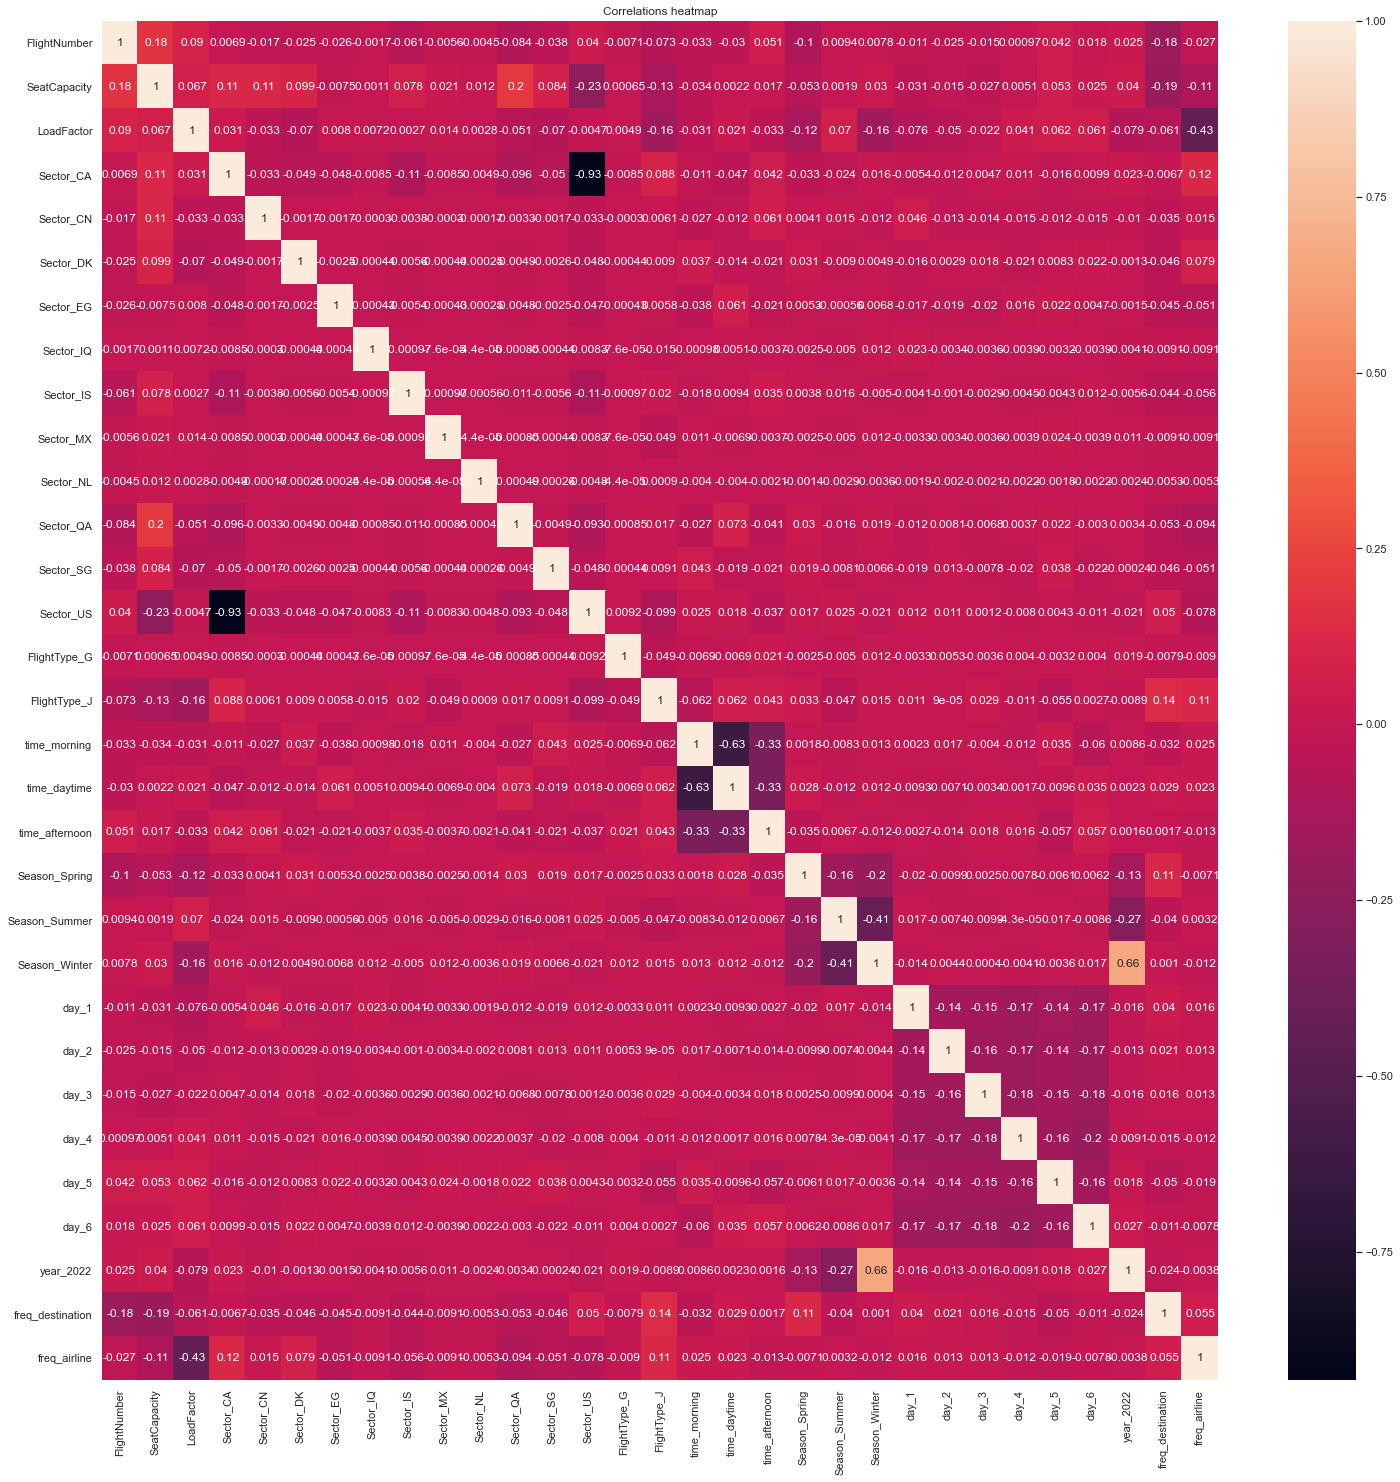

In [198]:
corr=df.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True)
plt.title("Correlations heatmap")
plt.show()

In [199]:
df.head()

Airline  FlightNumber Destination AircraftType  SeatCapacity  LoadFactor  \
0      IA           874         DEN          73W           142    0.408451   
1      JZ           818         YHM          AT7            74    0.189189   
2      IA           876         DEN          73W           142    0.570423   
3      CN           514         EST          AT7            72    0.333333   
4      LJ          3140         DEN          32A           186    0.204301   

   Sector_CA  Sector_CN  Sector_DK  Sector_EG  ...  Season_Winter  day_1  \
0          0          0          0          0  ...              1      0   
1          1          0          0          0  ...              1      0   
2          0          0          0          0  ...              1      0   
3          0          0          0          0  ...              1      0   
4          0          0          0          0  ...              1      0   

   day_2  day_3  day_4  day_5  day_6  year_2022  freq_destination  \
0      0      0      1      0      0          0            0.0460   
1      0      0      1      0      0          0            0.0163   
2      0      0      1      0      0          0            0.0460   
3      0      0      1      0      0          0            0.0315   
4      0      0      1      0      0          0            0.0460   

   freq_airline  
0         0.035  
1         0.012  
2         0.035  
3         0.064  
4         0.091  

[5 rows x 34 columns]

In [200]:
X = df.loc[:, df.columns != 'LoadFactor']
y = df['LoadFactor']
N, P = X.shape
X['FlightType_O']=0

In [201]:
X = X.drop(['Airline', 'FlightNumber', 'Destination', 'AircraftType'], axis=1)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [203]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
#result = 1-abs((y_test-y_pred)/(y_test))
print("R2 score: %3f" %r2_score(y_true=y_test,y_pred=y_pred))
print("Mean Squared Error: %3f" %MSE(y_test,y_pred))
print("Root Mean Squared Error: %3f" %np.sqrt(MSE(y_test,y_pred)))
print("Mean Absolute Error: %3f" %MAE(y_test,y_pred))
print("Intercept: %3f" %lr.intercept_)
#print(np.mean(result))

R2 score: 0.301683
Mean Squared Error: 0.053104
Root Mean Squared Error: 0.230443
Mean Absolute Error: 0.190638
Intercept: 0.606440


In [204]:
lr = RandomForestRegressor()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
#result = 1-abs((y_test-y_pred)/(y_test))
print("R2 score: %3f" %r2_score(y_true=y_test,y_pred=y_pred))
print("Mean Squared Error: %3f" %MSE(y_test,y_pred))
print("Root Mean Squared Error: %3f" %np.sqrt(MSE(y_test,y_pred)))
print("Mean Absolute Error: %3f" %MAE(y_test,y_pred))
#print("Intercept: %3f" %lr.intercept_)
#print(np.mean(result))

R2 score: 0.540505
Mean Squared Error: 0.034943
Root Mean Squared Error: 0.186930
Mean Absolute Error: 0.141781


In [205]:
#lr = RandomForestRegressor()
lr=AdaBoostRegressor(RandomForestRegressor())
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
#result = 1-abs((y_test-y_pred)/(y_test))
print("R2 score: %3f" %r2_score(y_true=y_test,y_pred=y_pred))
print("Mean Squared Error: %3f" %MSE(y_test,y_pred))
print("Root Mean Squared Error: %3f" %np.sqrt(MSE(y_test,y_pred)))
print("Mean Absolute Error: %3f" %MAE(y_test,y_pred))
#print("Intercept: %3f" %lr.intercept_)
#print(np.mean(result))

R2 score: 0.553788
Mean Squared Error: 0.033933
Root Mean Squared Error: 0.184208
Mean Absolute Error: 0.145430


RandomForestRegressor with adaboost is the best option and therefor crossvalidation will be used on that.

In [177]:
n_estimators = range(5,10)
param_grid = {
        'n_estimators': n_estimators
    }
                     
model = AdaBoostRegressor(RandomForestRegressor())
rs_cv = GridSearchCV(estimator= model, verbose = 2, param_grid=param_grid,scoring="r2")
rs_cv.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .....................................n_estimators=5; total time=  32.6s
[CV] END .....................................n_estimators=5; total time=  33.6s
[CV] END .....................................n_estimators=5; total time=  29.3s
[CV] END .....................................n_estimators=5; total time=  29.5s
[CV] END .....................................n_estimators=5; total time=  29.2s
[CV] END .....................................n_estimators=6; total time=  34.2s
[CV] END .....................................n_estimators=6; total time=  34.6s
[CV] END .....................................n_estimators=6; total time=  34.5s
[CV] END .....................................n_estimators=6; total time=  34.7s
[CV] END .....................................n_estimators=6; total time=  35.4s
[CV] END .....................................n_estimators=7; total time=  40.6s
[CV] END .....................................n_e

GridSearchCV(estimator=AdaBoostRegressor(base_estimator=RandomForestRegressor()),
             param_grid={'n_estimators': range(5, 10)}, refit=False,
             scoring='r2', verbose=2)

In [ ]:
n_estimators = range(5,101)
max_depth = range(1,11)
rng = np.random.RandomState(1)
test_acc = np.zeros((len(n_estimators), len(max_depth)))
for i in max_depth:
    boost =  AdaBoostRegressor(RandomForestRegressor(max_depth=i), random_state=rng)
    param_grid = {
        'n_estimators': n_estimators
    }
    
    boost_grid = GridSearchCV(estimator = boost, param_grid = param_grid, verbose = 2, scoring = "r2")
    
    boost_grid.fit(X, y)

    test_acc[:,i-1] = boost_grid.cv_results_['mean_test_score']

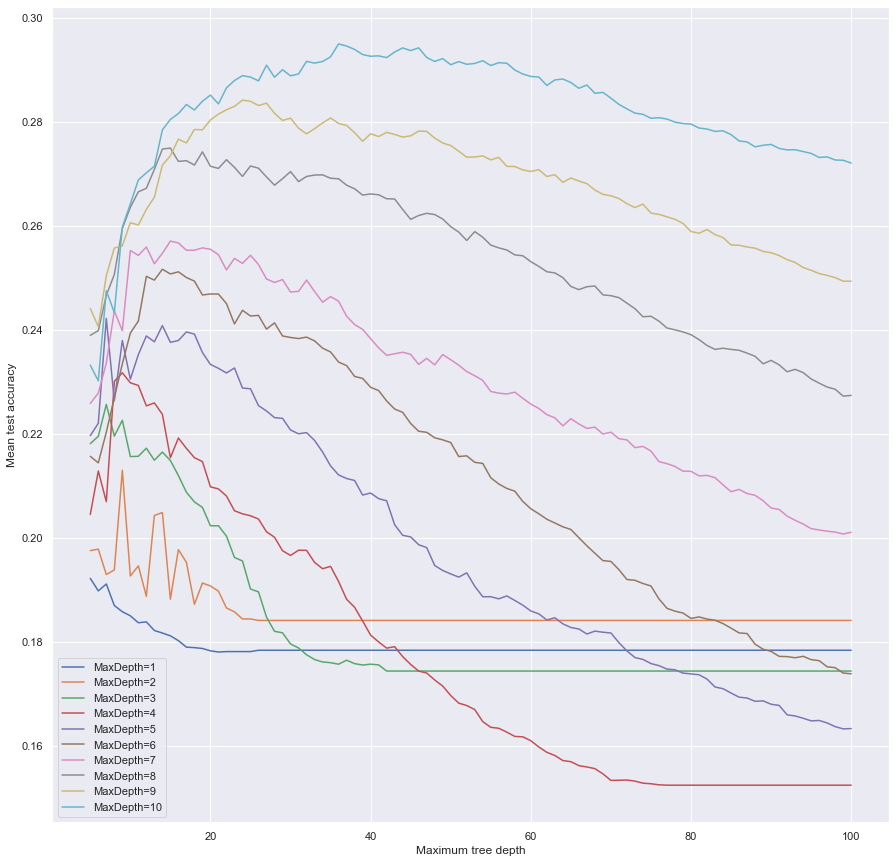

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(n_estimators, test_acc)
ax.set_xlabel('Maximum tree depth')
ax.set_ylabel('Mean test accuracy')
ax.legend(['MaxDepth=1','MaxDepth=2','MaxDepth=3','MaxDepth=4','MaxDepth=5','MaxDepth=6','MaxDepth=7','MaxDepth=8','MaxDepth=9','MaxDepth=10'])

In [27]:
df_predict = pd.read_excel('Future Schedule 20220301-20220331.xlsx')
df_predict['year'] = df_predict.ScheduleTime.apply(lambda x: x.year)
df_predict['day'] = df_predict.ScheduleTime.apply(lambda x: x.weekday())
df_predict['month'] = df_predict.ScheduleTime.apply(lambda x: x.month)
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'daytime', 'afternoon']
df_predict['time'] = pd.cut(df_predict.ScheduleTime.dt.hour, bins,labels=labels)
bins = ["Winter", "Spring", "Summer", "Fall"]
df_predict['Season'] = df_predict.month%12 //3
df_predict['Season'] = df_predict['Season'].apply(lambda x : bins[x])
df_predict=pd.get_dummies(df_predict,columns=['Sector','FlightType','time', 'Season','day','year'],drop_first=True)
df_predict = df_predict.drop(['ScheduleTime', 'month'], axis=1)
fe_ = df_predict.groupby("Destination").size()/len(df_predict)
df_predict['freq_destination'] = df_predict["Destination"].map(fe_).round(4)

fe_ = df_predict.groupby("Airline").size()/len(df)
df_predict['freq_airline'] = df_predict["Airline"].map(fe_).round(3)

X = df_predict.loc[:, df_predict.columns != 'LoadFactor']
X = X.drop(['Airline', 'FlightNumber', 'Destination', 'AircraftType'], axis=1)
X['Sector_MX']=0
X['Sector_NL']=0
X['Season_Spring']=0
X[ 'Season_Summer']=0
X['Season_Winter']=0
X['year_2022'] = 0 

In [ ]:
#predicting 
list(lr.predict(X))